In [73]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocations'),  # Corrected the filename here
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='root',
    database='target'
)
cursor = conn.cursor()

# Folder containing the CSV files (use raw string or forward slashes)
folder_path = r"C:\Users\seshi\OneDrive\Desktop\Target Sales"  # Option 1: Raw string notation
# OR
# folder_path = "C:/Users/seshi/OneDrive/Desktop/Target Sales"  # Option 2: Forward slashes

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Debugging: Check the file path
    print(f"Loading file from: {file_path}")
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()


Loading file from: C:\Users\seshi\OneDrive\Desktop\Target Sales\customers.csv
Loading file from: C:\Users\seshi\OneDrive\Desktop\Target Sales\orders.csv
Loading file from: C:\Users\seshi\OneDrive\Desktop\Target Sales\sellers.csv
Loading file from: C:\Users\seshi\OneDrive\Desktop\Target Sales\products.csv
Loading file from: C:\Users\seshi\OneDrive\Desktop\Target Sales\geolocation.csv
Loading file from: C:\Users\seshi\OneDrive\Desktop\Target Sales\payments.csv
Loading file from: C:\Users\seshi\OneDrive\Desktop\Target Sales\order_items.csv


In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector


db = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "root",
                            database = "target")

cur = db.cursor()

## List all unique cities where customers are located.

In [75]:
query = """ select distinct customer_city from customers """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


## Count the number of orders placed in 2017

In [76]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

cur.execute(query)

data = cur.fetchall()

"total orders placed in 2017 are", data[0][0]

('total orders placed in 2017 are', 180404)

 ## Find the total sales per category

In [77]:
query = """ select upper(products.product_category) category, 
round(sum(payments.payment_value),2) sales
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Category", "Sales"])
df

,Category,Sales
0,PERFUMERY,8107818.56
1,FURNITURE DECORATION,22882822.27
2,TELEPHONY,7790112.81
3,BED TABLE BATH,27400858.74
4,AUTOMOTIVE,13636709.30
...,...,...
69,CDS MUSIC DVDS,19190.88
70,LA CUISINE,46616.48
71,FASHION CHILDREN'S CLOTHING,12570.72
72,PC GAMER,34790.88


## Calculate the percentage of orders that were paid in installments

In [78]:
query = """ select ((sum(case when payment_installments >= 1 then 1
else 0 end))/count(*))*100 from payments
"""

cur.execute(query)

data = cur.fetchall()

"the percentage of orders that were paid in installments is", data[0][0]

('the percentage of orders that were paid in installments is',
 Decimal('99.9981'))

## Count the number of customers from each state

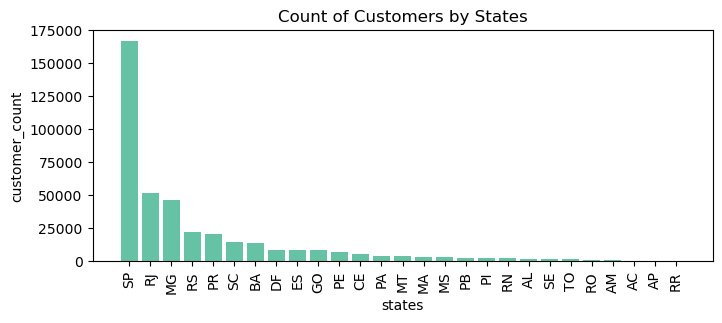

In [79]:
query = """ select customer_state ,count(customer_id)
from customers 
group by customer_state
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["state", "customer_count" ])
df = df.sort_values(by = "customer_count", ascending= False)

plt.figure(figsize = (8,3))
plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation = 90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of Customers by States")
plt.show()


## Calculate the number of orders per month in 2018.

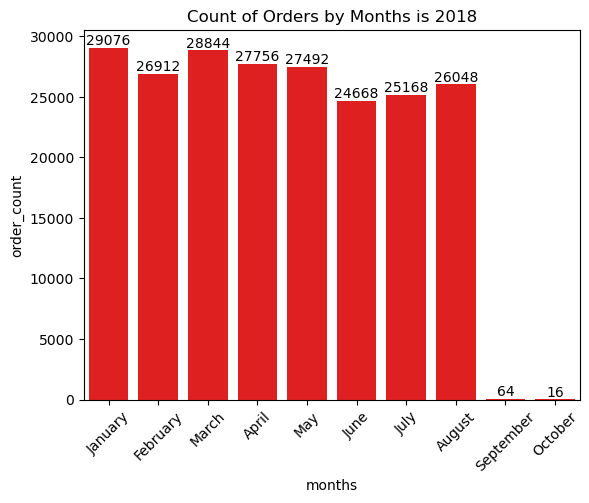

In [80]:
query = """ select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders where year(order_purchase_timestamp) = 2018
group by months
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["months", "order_count"])
o = ["January", "February","March","April","May","June","July","August","September","October"]

ax = sns.barplot(x = df["months"],y =  df["order_count"], data = df, order = o, color = "red")
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months is 2018")

plt.show()

## Find the average number of products per order, grouped by customer city

In [81]:
query = """with count_per_order as 
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns = ["customer city", "average products/order"])
df.head(10)

,customer city,average products/order
0,padre carvalho,56.00
1,celso ramos,52.00
2,datas,48.00
3,candido godoi,48.00
4,matias olimpio,40.00
5,cidelandia,32.00
6,curralinho,32.00
7,picarra,32.00
8,morro de sao paulo,32.00
9,teixeira soares,32.00


### Calculate the percentage of total revenue contributed by each product category.

In [82]:
query = """select upper(products.product_category) category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc"""


cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "percentage distribution"])
df.head()

,Category,percentage distribution
0,BED TABLE BATH,85.58
1,HEALTH BEAUTY,82.82
2,COMPUTER ACCESSORIES,79.22
3,FURNITURE DECORATION,71.47
4,WATCHES PRESENT,71.42


## Identify the correlation between product price and the number of times a product has been purchased.

In [83]:
import numpy as np

cur = db.cursor()

# SQL query
query = """
    SELECT products.product_category, 
           COUNT(order_items.product_id) AS order_count,
           ROUND(AVG(order_items.price), 2) AS avg_price
    FROM products 
    JOIN order_items
    ON products.product_id = order_items.product_id
    GROUP BY products.product_category
"""

cur.execute(query)
data = cur.fetchall()

# Creating a DataFrame
df = pd.DataFrame(data, columns=["Category", "order_count", "price"])


df["order_count"] = pd.to_numeric(df["order_count"])
df["price"] = pd.to_numeric(df["price"])

# Extracting the relevant columns
arr1 = df["order_count"]
arr2 = df["price"]

# Calculating the correlation
correlation_matrix = np.corrcoef(arr1, arr2)
correlation = correlation_matrix[0, 1]  # Get the correlation between order_count and price

print("The correlation is:", correlation)


The correlation is: -0.10631514167157562


## Calculate the total revenue generated by each seller, and rank them by revenue

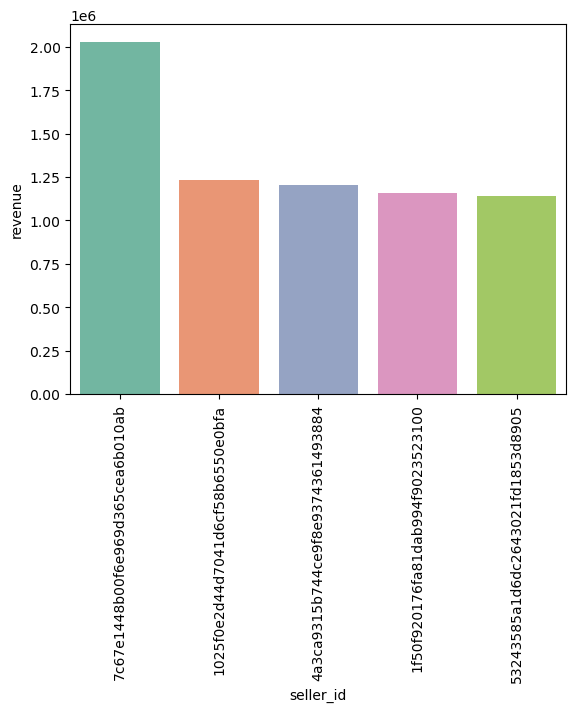

In [84]:
query = """ with revenue as (select order_items.seller_id,sum(payments.payment_value) revenue
from order_items
join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id)

select *, rank() over(order by revenue desc) as rn from revenue """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df = df.head()
sns.barplot(x = "seller_id", y = "revenue", data = df)
plt.xticks(rotation = 90)
plt.show()

### Calculate the moving average of order values for each customer over their order history

In [85]:
query = """with moving as (select orders.customer_id, orders.order_purchase_timestamp, 
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id)

select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from moving"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
...,...,...,...,...
831083,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
831084,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
831085,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
831086,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


In [86]:
query = """with p as (select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment
from orders
join payments
on orders.order_id = payments.order_id
group by years,months order by years, months)

select  years , months,payment, sum(payment)
over(order by years,months) cumulative_sales
from p
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,2016,9,2017.92,2.017920e+03
1,2016,10,472723.84,4.747418e+05
2,2016,12,156.96,4.748987e+05
3,2017,1,1107904.32,1.582803e+06
4,2017,2,2335264.08,3.918067e+06
5,2017,3,3598908.80,7.516976e+06
6,2017,4,3342304.24,1.085928e+07
7,2017,5,4743350.56,1.560263e+07
8,2017,6,4090211.04,1.969284e+07
9,2017,7,4739063.36,2.443191e+07


## Calculate the year-over-year growth rate of total sales

In [87]:
query = """with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, ((payment - lag(payment, 1) over(order by years))/
lag(payment, 1) over(order by years)) * 100 from a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "yoy % growth"])
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.703759
2,2018,20.000924


### Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase

In [88]:
query = """WITH y AS (
    SELECT customers.customer_id,
           MIN(orders.order_purchase_timestamp) AS first_order
    FROM customers
    JOIN orders
      ON customers.customer_id = orders.customer_id
    GROUP BY customers.customer_id
),
z AS (
    SELECT y.customer_id,
           COUNT(DISTINCT orders.order_purchase_timestamp) AS next_order
    FROM y 
    JOIN orders
      ON orders.customer_id = y.customer_id
     AND orders.order_purchase_timestamp > y.first_order
     AND orders.order_purchase_timestamp < DATE_ADD(y.first_order, INTERVAL 6 MONTH)
    GROUP BY y.customer_id
)
SELECT 
    100 * (COUNT(DISTINCT z.customer_id) / COUNT(DISTINCT y.customer_id)) AS retention_rate
FROM y 
LEFT JOIN z 
  ON y.customer_id = z.customer_id;"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns=["retention_rate"])

df

,retention_rate
0,0.0000


## Identify the top 3 customers who spent the most money in each year

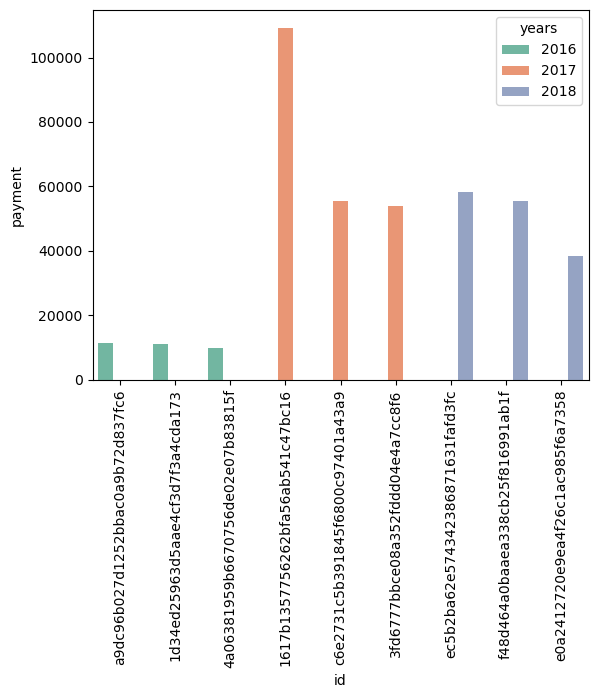

In [89]:
query = """select years, customer_id, payment, rn
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) rn
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where rn <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()